# BiLSTM-CRF with word2vec embedding

## For dataset 2

In [ ]:
# !pip install gensim

In [2]:
# !pip install pytorch-crf

In [1]:
import json
import torch
import random
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchcrf import CRF
from torch.nn import LSTM, Embedding, Linear, BCELoss
from sklearn.metrics import f1_score
import gensim.downloader as api
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence

In [2]:
# Load pre-trained word embeddings (word2vec)
word_vectors = api.load("word2vec-google-news-300")

startTag = "<START>"
stopTag = "<STOP>"
word_to_idx = {word: idx + 1 for idx, word in enumerate(word_vectors.index_to_key)}
label_to_idx = {'B':0, 'I':1, 'O':2, '<START>':3, '<STOP>':4}

In [3]:
def seq_prep(seq, to_ix):
    vocab_size = len(to_ix)
    idxs = []
    for w in seq:
        if w in to_ix:
            idxs.append(to_ix[w])
        else:
            idxs.append(random.randint(0, vocab_size - 1))
    return torch.tensor(idxs, dtype=torch.long)

def log_sum_exp(vec):
    _, idx = torch.max(vec, 1)
    max_score = vec[0, idx.item()]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

In [4]:
class BiLSTM_CRF(nn.Module):
    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim, word_embeddings):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)
        self.word_embeds = nn.Embedding.from_pretrained(word_embeddings, freeze=True)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2, num_layers=1, bidirectional=True)
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)
        self.transitions = nn.Parameter(torch.randn(self.tagset_size, self.tagset_size))
        self.transitions.data[tag_to_ix[startTag], :] = -10000
        self.transitions.data[:, tag_to_ix[stopTag]] = -10000
        self.hidden = (torch.randn(2, 1, self.hidden_dim // 2), torch.randn(2, 1, self.hidden_dim // 2))

    def _forward_alg(self, feats):
        init_alphas = torch.full((1, self.tagset_size), -10000.)
        init_alphas[0][self.tag_to_ix[startTag]] = 0.
        forward_var = init_alphas
        for feat in feats:
            alphas_t = []
            for next_tag in range(self.tagset_size):
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                trans_score = self.transitions[next_tag].view(1, -1)
                next_tag_var = forward_var + trans_score + emit_score
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[stopTag]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def get_features(self, sentence):
        self.hidden = (torch.randn(2, 1, self.hidden_dim // 2), torch.randn(2, 1, self.hidden_dim // 2))
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        lstm_out = lstm_out.view(len(sentence), self.hidden_dim)
        lstm_feats = self.hidden2tag(lstm_out)
        return lstm_feats

    def sentence_score(self, feats, tags):
        score = torch.zeros(1)
        tags = torch.cat([torch.tensor([self.tag_to_ix[startTag]], dtype=torch.long), tags])
        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[stopTag], tags[-1]]
        return score

    def neg_log_likelihood(self, sentence, tags):
        feats = self.get_features(sentence)
        forward_score = self._forward_alg(feats)
        gold_score = self.sentence_score(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence):  
        feats = self.get_features(sentence)
        backpointers = []
        init_vvars = torch.full((1, self.tagset_size), -10000.)
        init_vvars[0][self.tag_to_ix[startTag]] = 0

        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []
            viterbivars_t = []
            for next_tag in range(self.tagset_size):
                next_tag_var = forward_var + self.transitions[next_tag]
                _, idx = torch.max(next_tag_var, 1)
                best_tag_id = idx.item()
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)
        
        terminal_var = forward_var + self.transitions[self.tag_to_ix[stopTag]]
        _, idx = torch.max(terminal_var, 1)
        best_tag_id = idx.item()
        path_score = terminal_var[0][best_tag_id]
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
            
        start = best_path.pop()
        assert start == self.tag_to_ix[startTag]
        best_path.reverse()
        return path_score, best_path

In [5]:
def train_model(word_vectors, word_to_idx, train_data, val_data):
    EMBEDDING_DIM = word_vectors.vector_size 
    HIDDEN_DIM = 8
    model = BiLSTM_CRF(len(word_to_idx), label_to_idx, EMBEDDING_DIM, HIDDEN_DIM, torch.FloatTensor(word_vectors.vectors))
    optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)
    
    train_losses = []
    val_losses = []
    train_f1_scores = []
    val_f1_scores = []

    num_epochs = 15
    for epoch in range(num_epochs): 
        # Training
        model.train()
        total_loss = 0
        train_preds = []
        train_labels = []
        for sentence, tags in train_data:
            model.zero_grad()
            sentence_in = seq_prep(sentence, word_to_idx)
            targets = torch.tensor([label_to_idx[t] for t in tags], dtype=torch.long)
            loss = model.neg_log_likelihood(sentence_in, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            train_labels.extend(tags)
            with torch.no_grad():
                predictions = model(sentence_in)
                predicted_labels = [list(label_to_idx.keys())[list(label_to_idx.values()).index(p)] for p in predictions[1]]
                train_preds.extend(predicted_labels)
            
        train_loss = total_loss / len(train_data)
        train_losses.append(train_loss)
        train_f1 = f1_score(train_labels, train_preds, average='macro')
        train_f1_scores.append(train_f1)

        # Validation
        model.eval()
        val_loss = 0
        all_predictions = []
        all_labels = []
        with torch.no_grad():
            for sentence, labels in val_data:
                sentence_in = seq_prep(sentence, word_to_idx)
                targets = torch.tensor([label_to_idx[t] for t in labels], dtype=torch.long)
                predictions = model(sentence_in)
                val_loss += model.neg_log_likelihood(sentence_in, targets).item()

                predicted_labels = [list(label_to_idx.keys())[list(label_to_idx.values()).index(p)] for p in predictions[1]]
                all_predictions.extend(predicted_labels)
                all_labels.extend(labels)

        val_loss /= len(val_data)
        val_losses.append(val_loss)
        val_f1 = f1_score(all_labels, all_predictions, average='macro')
        val_f1_scores.append(val_f1)

        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Training F1: {train_f1:.4f}, Validation F1: {val_f1:.4f}')

    # Plots
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()

    plt.plot(range(1, len(train_f1_scores) + 1), train_f1_scores, label='Training F1 Score')
    plt.plot(range(1, len(val_f1_scores) + 1), val_f1_scores, label='Validation F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.title('Training and Validation F1 Scores')
    plt.legend()
    plt.show()

    return model

In [6]:
def load_data(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    
    training_data = []
    for key, value in data.items():
        text = value["text"]
        labels = value["labels"]
        training_data.append((text, " ".join(labels)))

    data = []
    for i in training_data:
        data.append((i[0].split(), i[1].split()))
    return data

train_data = load_data('ATE_train.json')
val_data = load_data('ATE_val.json')
test_data = load_data('ATE_test.json')

Epoch 1/15, Training Loss: 6.6525, Validation Loss: 5.8877, Training F1: 0.3145, Validation F1: 0.3153
Epoch 2/15, Training Loss: 5.8454, Validation Loss: 5.3750, Training F1: 0.3161, Validation F1: 0.3456
Epoch 3/15, Training Loss: 5.2504, Validation Loss: 4.8761, Training F1: 0.3749, Validation F1: 0.4513
Epoch 4/15, Training Loss: 4.5942, Validation Loss: 4.2656, Training F1: 0.4837, Validation F1: 0.5266
Epoch 5/15, Training Loss: 4.1693, Validation Loss: 3.9774, Training F1: 0.5823, Validation F1: 0.6008
Epoch 6/15, Training Loss: 3.8124, Validation Loss: 3.6987, Training F1: 0.6414, Validation F1: 0.6327
Epoch 7/15, Training Loss: 3.5626, Validation Loss: 3.5033, Training F1: 0.6824, Validation F1: 0.6552
Epoch 8/15, Training Loss: 3.3970, Validation Loss: 3.4567, Training F1: 0.7154, Validation F1: 0.6702
Epoch 9/15, Training Loss: 3.2591, Validation Loss: 3.3253, Training F1: 0.7300, Validation F1: 0.6577
Epoch 10/15, Training Loss: 3.0817, Validation Loss: 3.2943, Training F1:

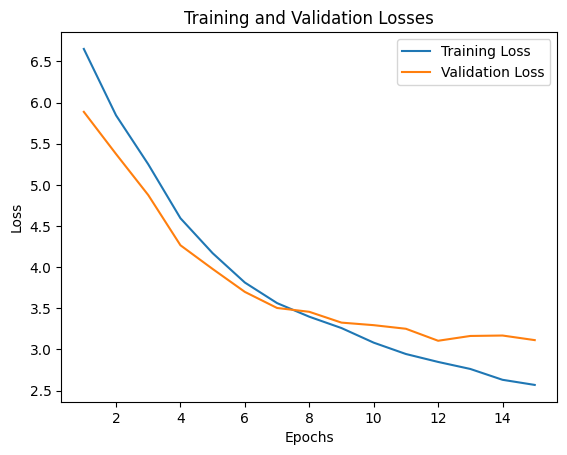

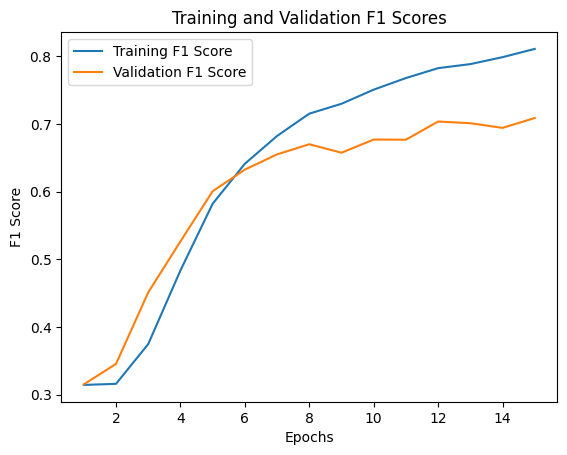

In [7]:
model = train_model(word_vectors, word_to_idx, train_data, val_data)

In [8]:
torch.save(model.state_dict(), 't2_model4_word2vec.pt') 